let us start by importing the required functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors import vensimDLLwrapper
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

NOTE: I decided not to do scenario discovery at this early phase. scenario discovery at this phase sometimes creates conflicting subspaces for different objectives, and some are not even relevant to land use policy, e.g. directly pointing to immigration rate and fertility rate. So, the idea now is to follow the basic mordm structure. we optimize current land use options available for the objectives through the evolutionary algorithm (since the context is land use policy), do uncertainty analysis, and then do scenario discovery AFTERWARDS by lowering the objective threshold to optimize further. Because the current robustness structure is minimax/maximin. This further optimization can link to other non land use policies, and it is fine because it can pinpoint the fundamental reason of these options to emerge, such as disparity of development between Jakarta and any other cities which cause high immigration rate. 

What we can do after that is to either motivate the PRIM result with text (like Bramka did), to integrate the scenario discovery result to the model and run again, or to design pathways combining the scenario discovery insights. I personally prefer the first option because i dont have time. But if you want to you can do the latter options it is fine. BUT please do not change the current structure for both model and script. Improve it from the last step of this page.

# Binh Dai 

In [2]:
vensimModel = VensimModel("BaseCaseBinh", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand.vpm" )

In [3]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
            RealParameter("PopFracExtensive", 0, 0.5),
#             RealParameter("PopFracInteg", 0, 0.5)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [4]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [5]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand.tar.gz


In [6]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

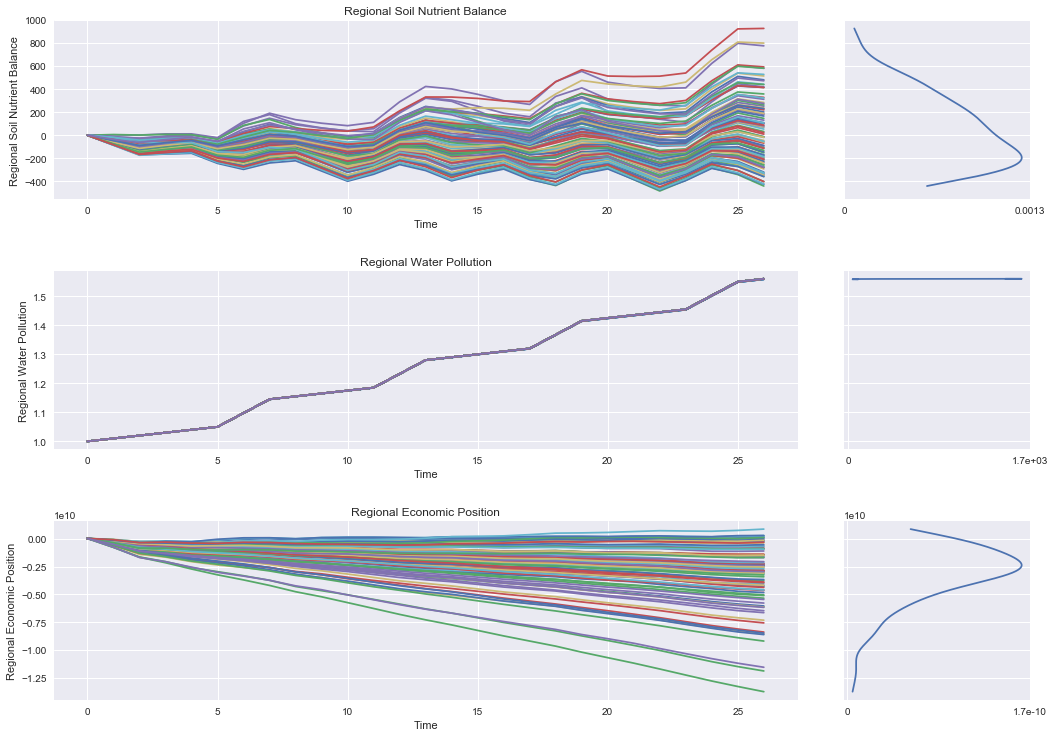

In [7]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [2]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_BinhDai_norand.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_BinhDai_up.tar.gz


In [2]:
# outputs = list(results[1].keys())[1:] 

# for x in outputs:
#     fig = lines(results, outcomes_to_show=[x], density=KDE)
# plt.show()

In [3]:
experiments, outcomes= results

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 96 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.85, coverage: 0.8854166666666666, density: 1.0 restricted_dimensions: 2


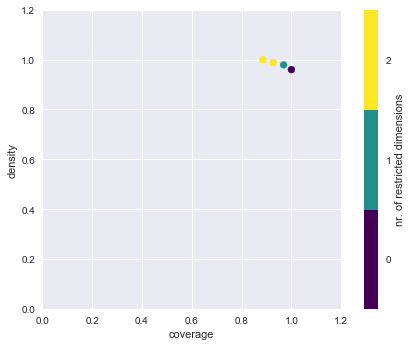

In [5]:
box_1.show_tradeoff()
# mpld3.display()

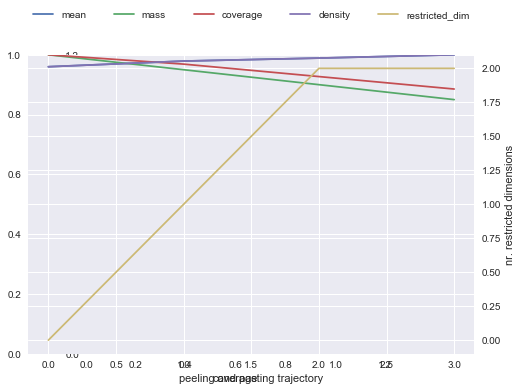

In [6]:
box_1.show_ppt()
plt.show()

coverage    0.927083
density     0.988889
mass             0.9
mean        0.988889
res dim            2
Name: 2, dtype: object

                box 2                                 
                  min       max              qp values
BaseTE       0.257423  0.399259  [0.21912943971083584]
CostIntense  0.629430  1.196453  [0.43253433943522224]



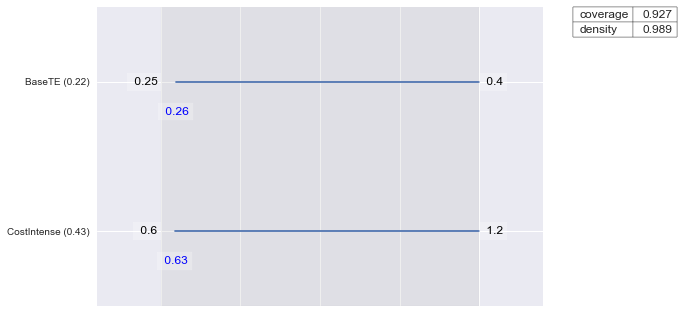

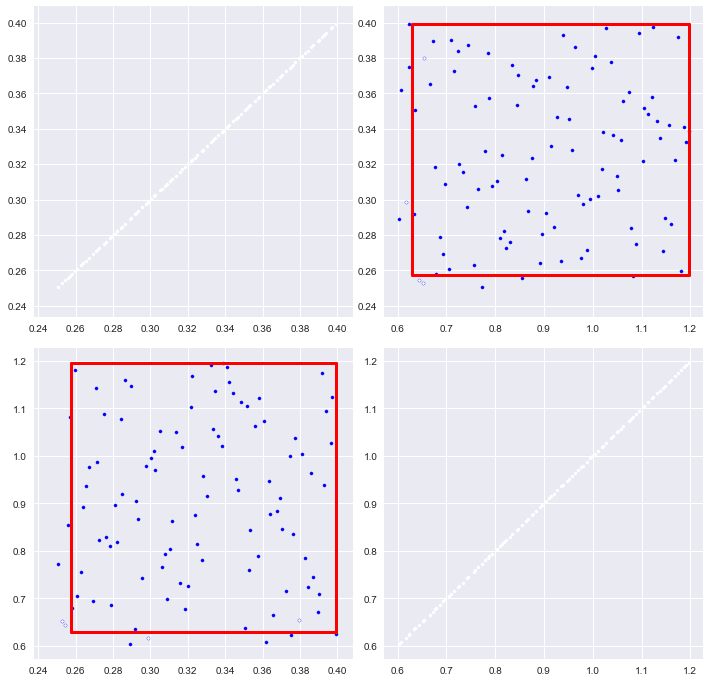

In [7]:
valuebox = 2
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [25]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.286] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 85 cases of interest
[MainProcess/INFO] mean: 0.9852941176470589, mass: 0.68, coverage: 0.788235294117647, density: 0.9852941176470589 restricted_dimensions: 6


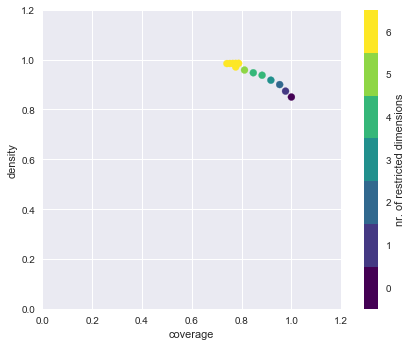

In [26]:
box_1.show_tradeoff()
# mpld3.display()

coverage    0.811765
density     0.958333
mass            0.72
mean        0.958333
res dim            5
Name: 6, dtype: object

                                                  box 6                \
                                                    min           max   
Extense Selling                                3.008119      7.706140   
Freshwater Shrimp Recruitment per hectare  10011.103477  28929.604136   
BaseTE                                         0.257423      0.399259   
ExtShrimpFarmArea                              0.821723      1.181141   
CostFresh                                      0.801832      1.731193   

                                                                                       
                                                                            qp values  
Extense Selling                                                 [0.30465124034549751]  
Freshwater Shrimp Recruitment per hectare                       [0.30465124034549751]  
BaseTE 

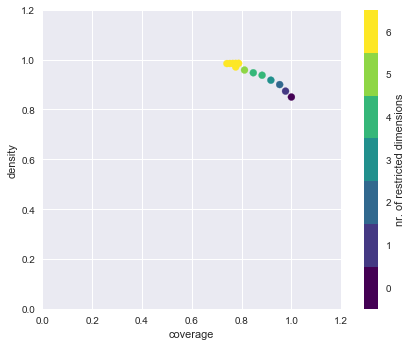

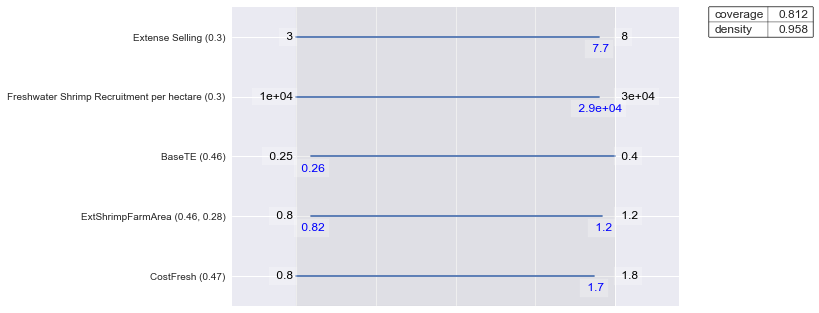

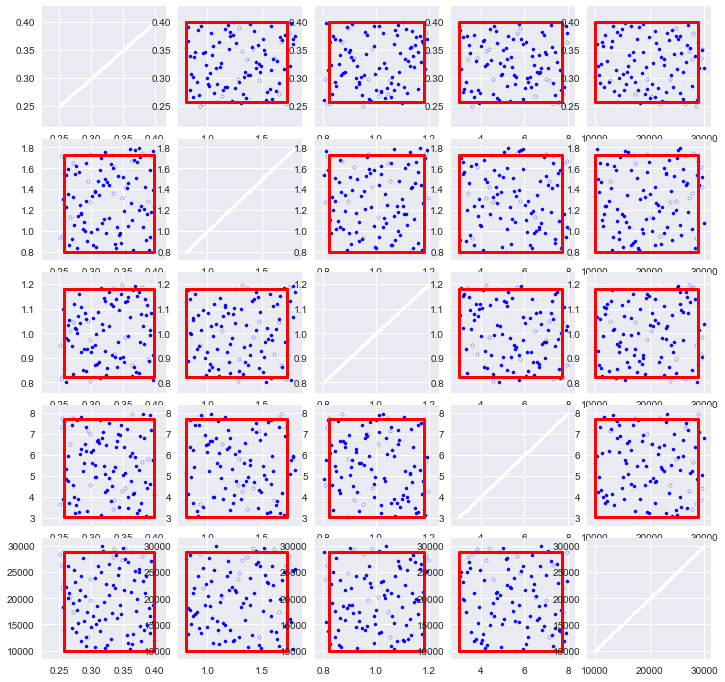

In [27]:
valuebox = 6
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

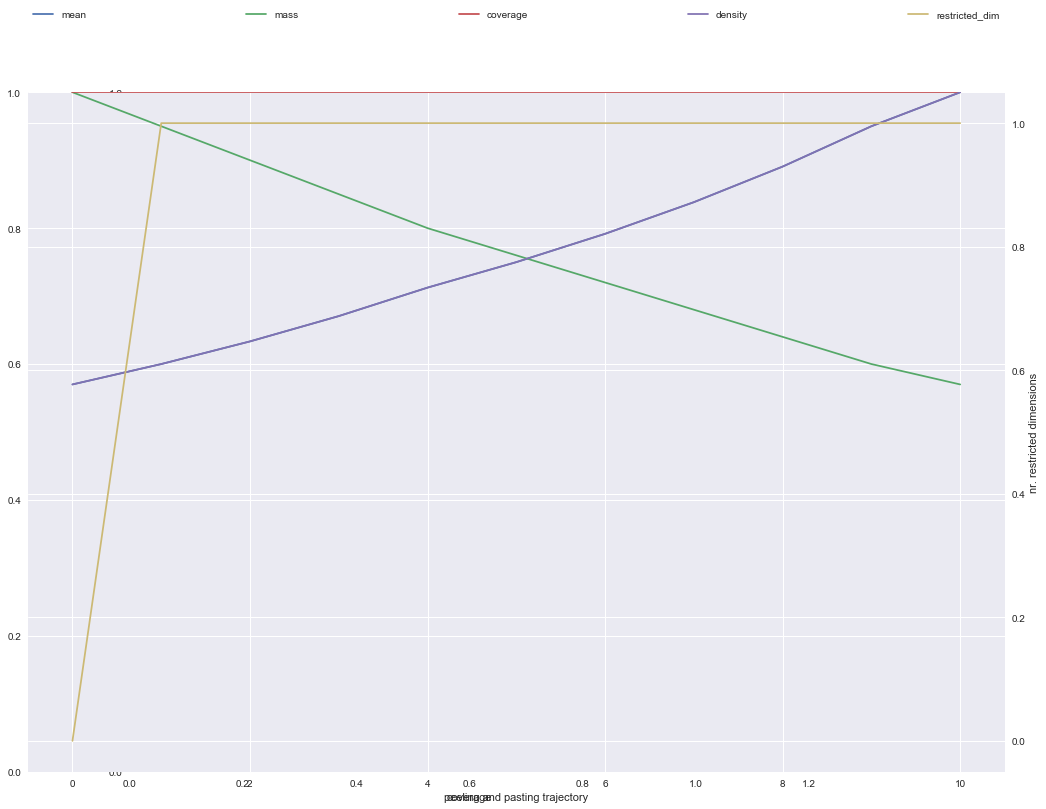

In [40]:
box_1.show_ppt()
plt.show()

coverage       1
density      0.6
mass        0.95
mean         0.6
res dim        1
Name: 1, dtype: object

                     box 1                                 
                       min       max              qp values
PopFracExtensive  0.004799  0.475532  [0.31456397779085599]



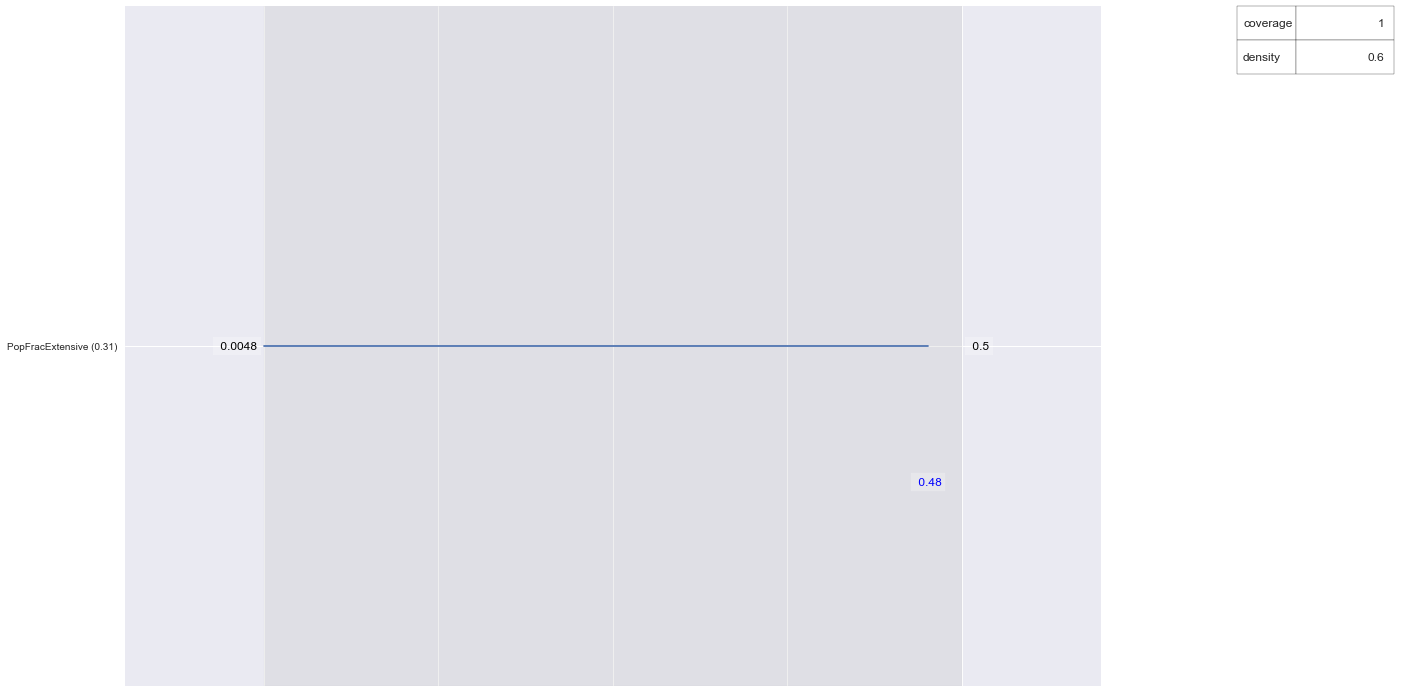

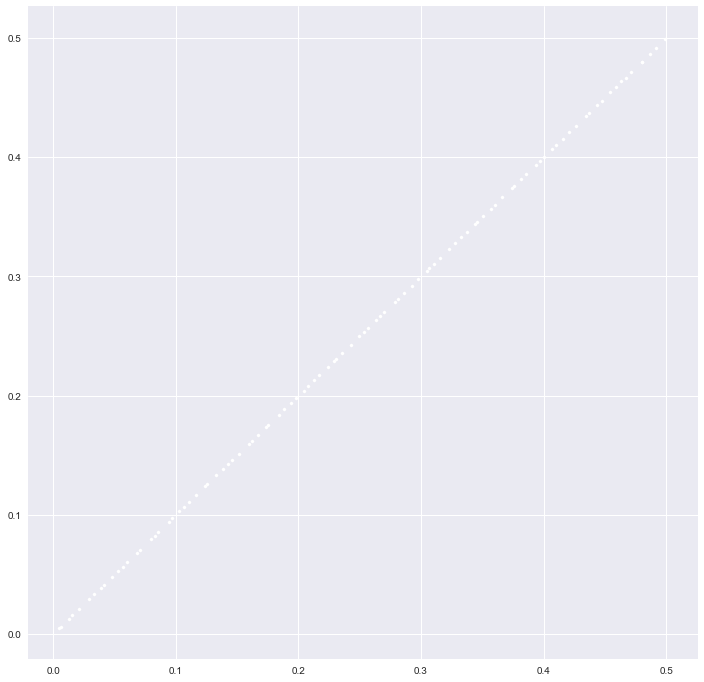

In [41]:
valuebox = 1
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [30]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<1000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 27 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.23, coverage: 0.8518518518518519, density: 1.0 restricted_dimensions: 10


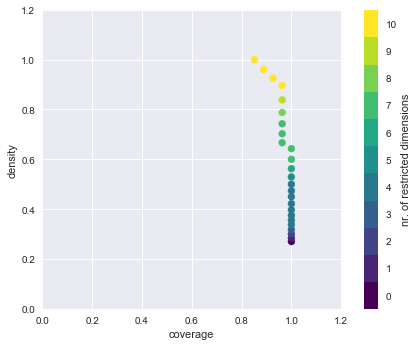

In [31]:
box_2.show_tradeoff()
# mpld3.display()

coverage           1
density     0.642857
mass            0.42
mean        0.642857
res dim            7
Name: 15, dtype: object

                                     box 15               \
                                        min          max   
FloodDuration                      1.003827     1.634151   
FertPriceChngRate                  1.011914     1.048851   
CostExtense                        0.031004     0.049917   
Intensive Shrimp Survival Rate     0.518625     0.978830   
TECoefficient                      0.026387     0.039535   
Dredging cost                    570.095196  1989.961134   
Freshwater Shrimp Survival Rate    0.202499     0.484768   

                                                                             
                                                                  qp values  
FloodDuration                                       [0.0032022068192208947]  
FertPriceChngRate                [0.28362261854881432, 0.56976282271859435]  
CostExtense      

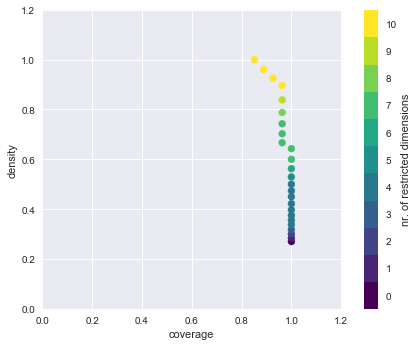

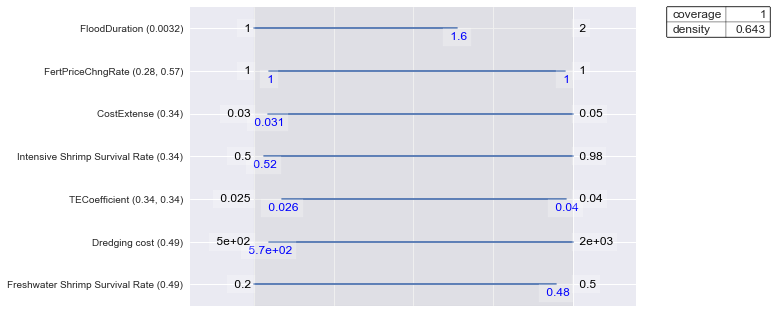

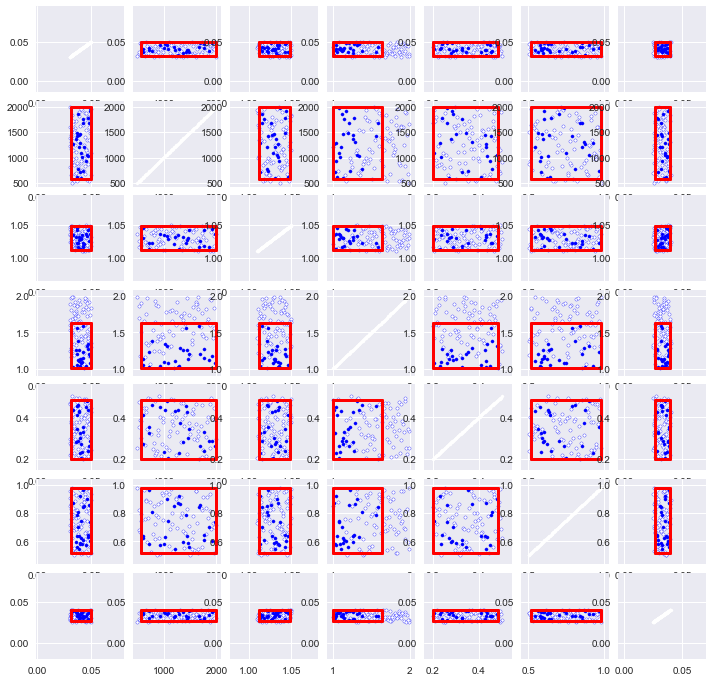

In [33]:
valuebox = 15
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

# Thanh Phu

In [8]:
vensimModel = VensimModel("BaseCaseThanh", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand.vpm" )

In [9]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
#             RealParameter("PopFracExtensive", 0, 0.5),
            RealParameter("PopFracInteg", 0, 0.5)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [10]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [11]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand.tar.gz


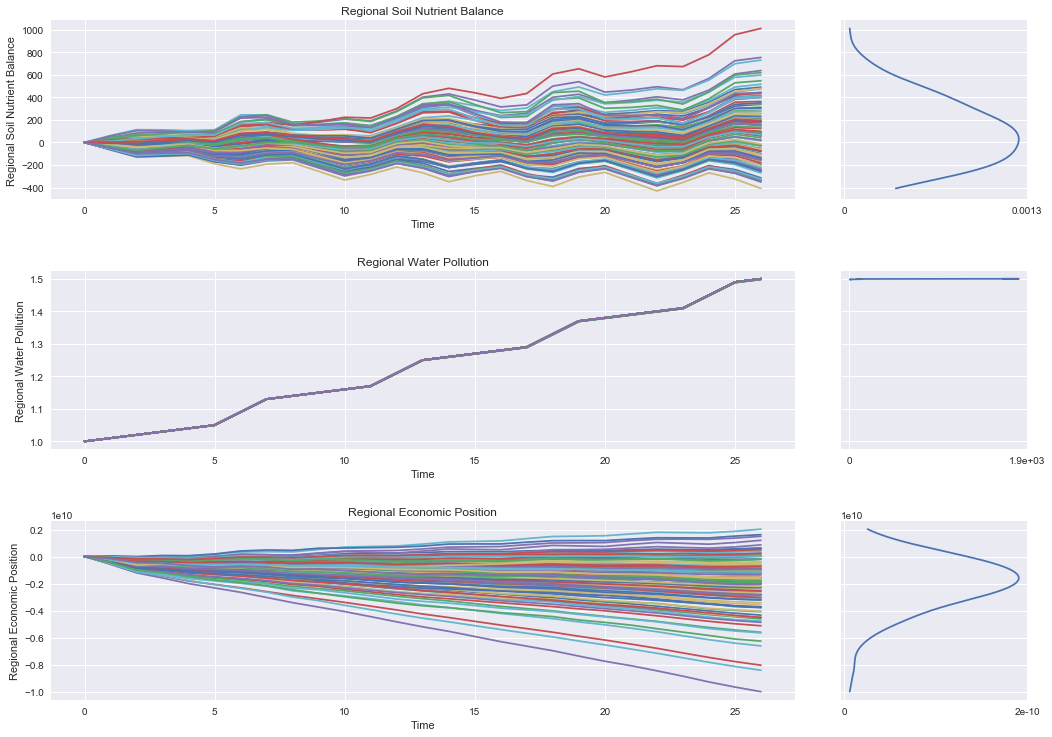

In [12]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [56]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

In [34]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_up.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_up.tar.gz


In [1]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], density=KDE)
plt.show()

NameError: name 'results' is not defined

In [35]:
experiments, outcomes= results

In [36]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 97 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.85, coverage: 0.8762886597938144, density: 1.0 restricted_dimensions: 3


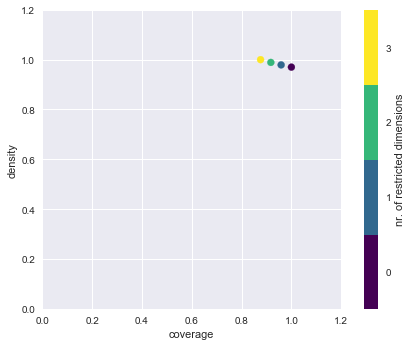

In [37]:
box_1.show_tradeoff()
# mpld3.display()

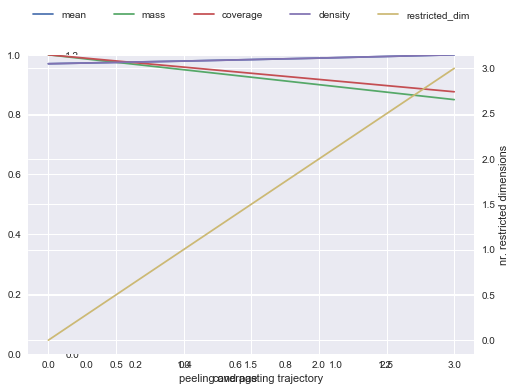

In [38]:
box_1.show_ppt()
plt.show()

coverage    0.876289
density            1
mass            0.85
mean               1
res dim            3
Name: 3, dtype: object

                    box 3                                 
                      min       max              qp values
CostIntense      0.638328  1.197461  [0.38684524453867164]
Extense Selling  3.026429  7.688702  [0.38684524453867164]
BackupFraction   1.051650  1.287297                  [1.0]



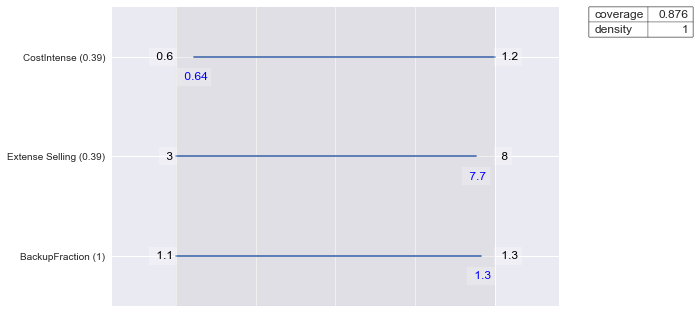

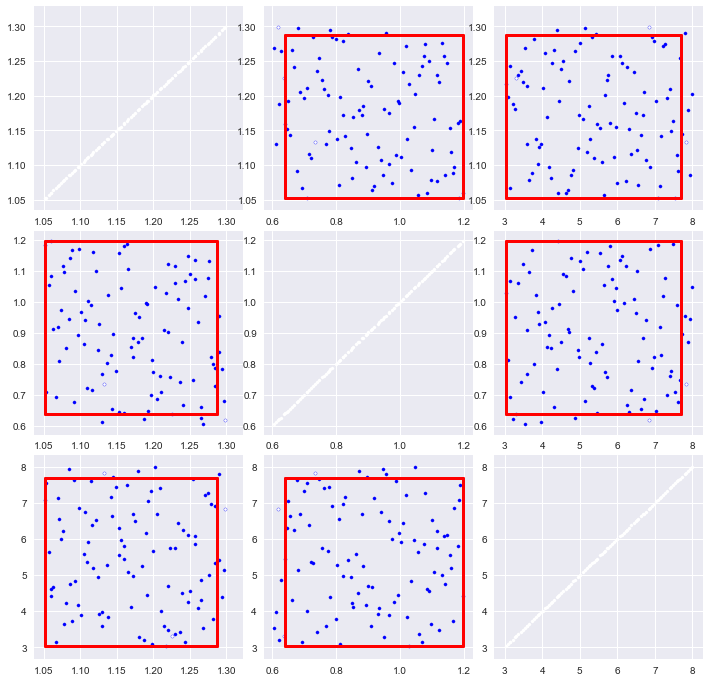

In [39]:
valuebox = 3
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [54]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.6)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 3 cases of interest
[MainProcess/INFO] mean: 0.6, mass: 0.05, coverage: 1.0, density: 0.6 restricted_dimensions: 6


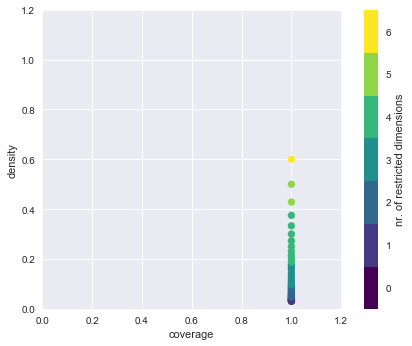

In [55]:
box_1.show_tradeoff()

coverage       1
density      0.6
mass        0.05
mean         0.6
res dim        6
Name: 40, dtype: object

                  box 40                                                      
                     min       max                                   qp values
CostFresh       1.257181  1.555888                  [0.27520751953124989, 0.5]
BackupFraction  1.129880  1.298344                       [0.36788242993990583]
CostRiceUnit    1.037704  6.259471                                       [0.5]
CostExtense     0.030320  0.043196  [0.68255999999999972, 0.36788242993990583]
BaseTE          0.299599  0.366948  [0.68255999999999972, 0.68255999999999972]
CostIntense     0.611109  0.793568  [0.68255999999999972, 0.68255999999999972]



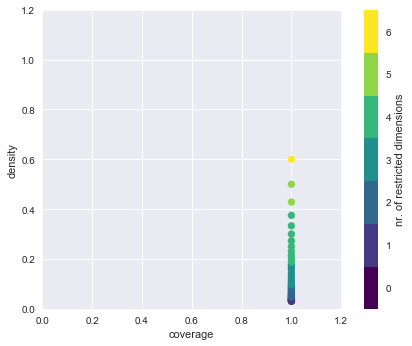

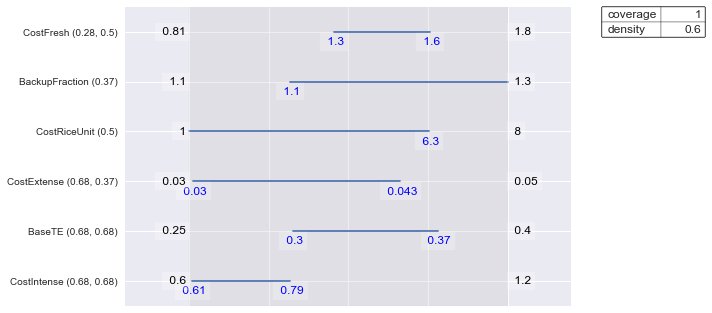

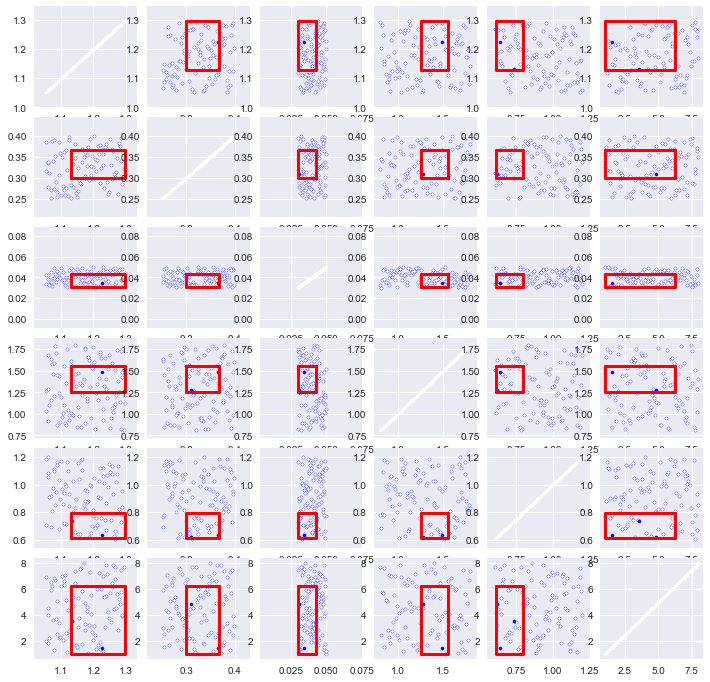

In [57]:
valuebox = 40
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [65]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.282] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 94 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.72, coverage: 0.7659574468085106, density: 1.0 restricted_dimensions: 5


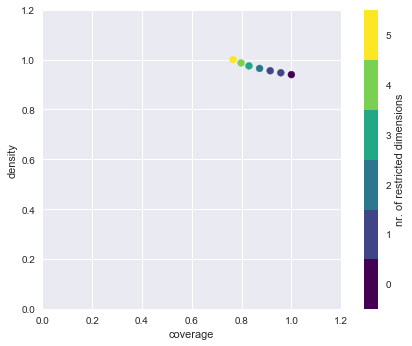

In [66]:
box_1.show_tradeoff()
# mpld3.display()

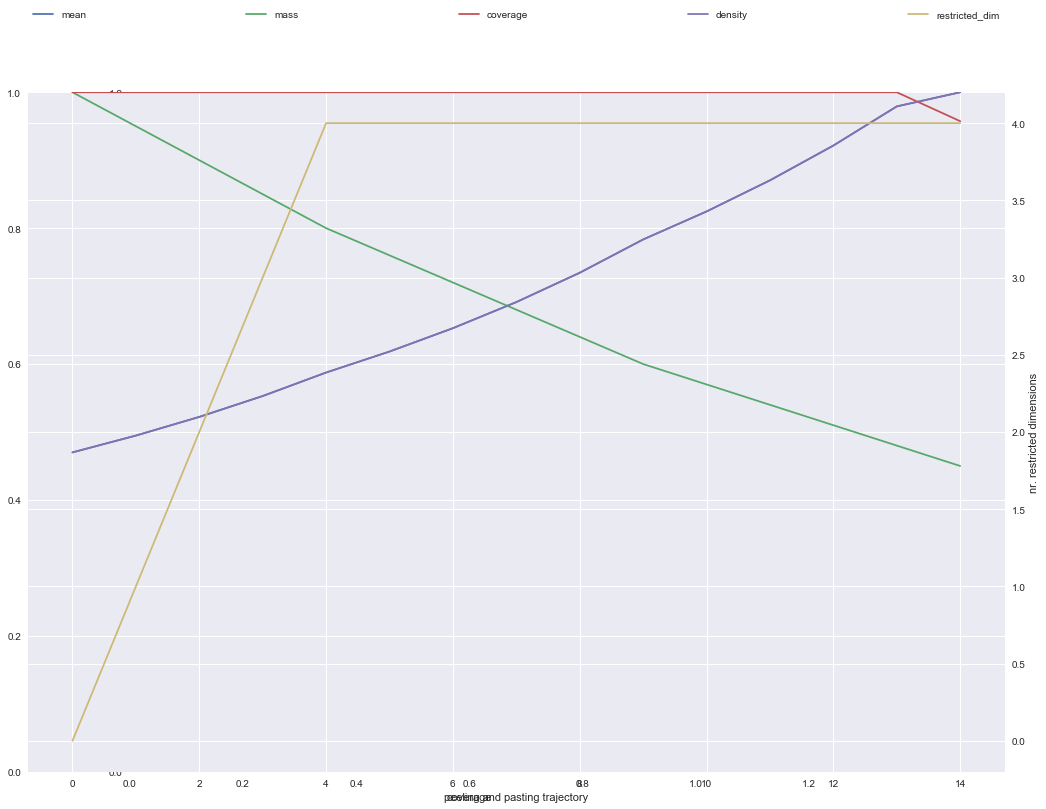

In [68]:
box_1.show_ppt()
plt.show()

coverage    0.765957
density            1
mass            0.72
mean               1
res dim            5
Name: 6, dtype: object

                                                 box 6                 \
                                                   min            max   
Extensive Shrimp Recruitment per hectare  76990.100815  124708.303663   
FertStartPrice                                3.200019       7.951038   
CostExtense                                   0.031197       0.049870   
Dredging cost                               574.686066    1990.651680   
BackupFraction                                1.061612       1.287297   

                                                                      
                                                           qp values  
Extensive Shrimp Recruitment per hectare       [0.38532955416299863]  
FertStartPrice                                 [0.38532955416299863]  
CostExtense                                    [0.39016331431830065]  
Dred

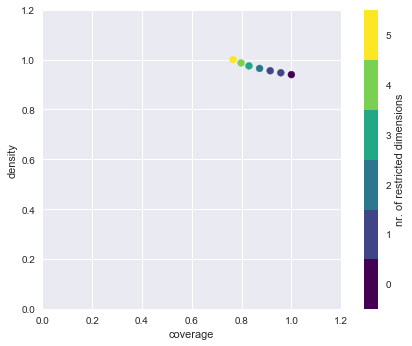

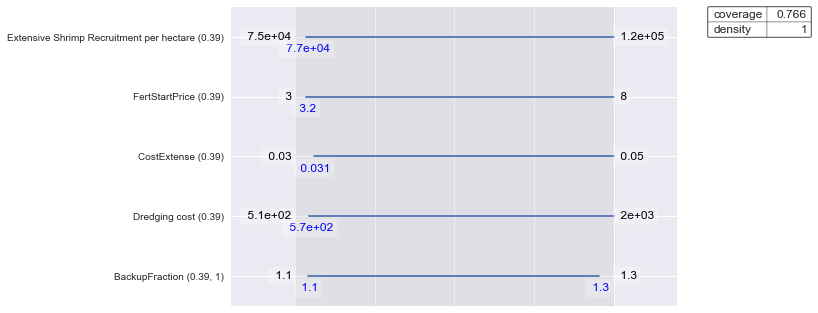

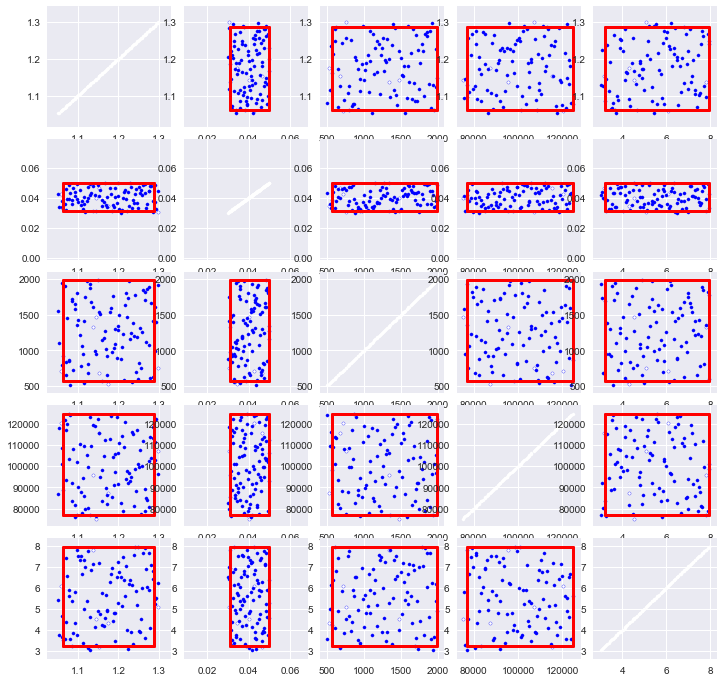

In [67]:
valuebox = 6
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [68]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<2000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 87 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.68, coverage: 0.7816091954022989, density: 1.0 restricted_dimensions: 6


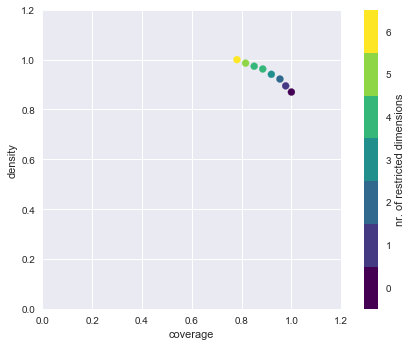

In [69]:
box_2.show_tradeoff()
# mpld3.display()

In [73]:
box1.show_ppt()
plt.show()

NameError: name 'box1' is not defined

coverage    0.781609
density            1
mass            0.68
mean               1
res dim            6
Name: 7, dtype: object

                       box 7               \
                         min          max   
RiceFarmSize        0.264585     1.439823   
BackupFraction      1.051650     1.287297   
Dredging cost     507.535193  1922.839948   
LeachingRate        3.039248     8.634940   
CostRiceUnit        1.037704     7.696523   
ExogNutAvailRate    8.012617    14.728783   

                                                               
                                                    qp values  
RiceFarmSize      [0.057638441960939826, 0.38632957433917658]  
BackupFraction                          [0.14725056289587413]  
Dredging cost                           [0.14725056289587413]  
LeachingRate                             [0.1512213896532916]  
CostRiceUnit                            [0.38632957433917658]  
ExogNutAvailRate                        [0.38632957433917658] 

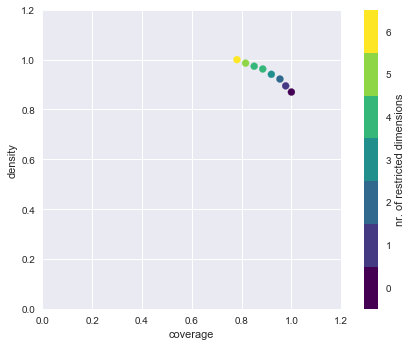

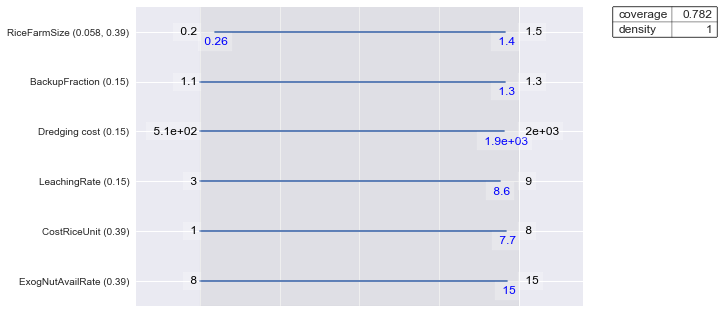

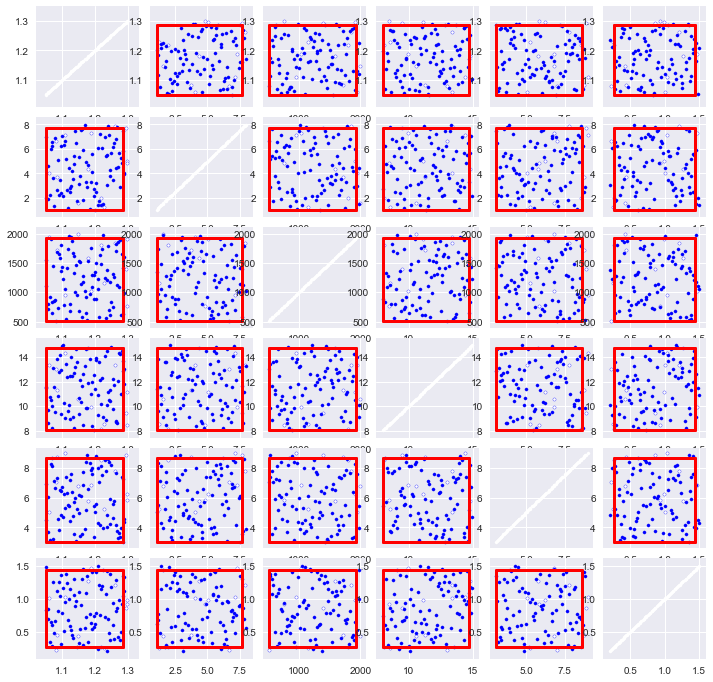

In [70]:
valuebox = 7
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

# Integrated Model

In [13]:
vensimModel = VensimModel("BaseCaseInteg", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand.vpm" )

In [14]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
            RealParameter("PopFracExtensive", 0, 0.5),
            RealParameter("PopFracInteg", 0, 0.5)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [15]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [16]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_integ_norand.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_integ_norand.tar.gz


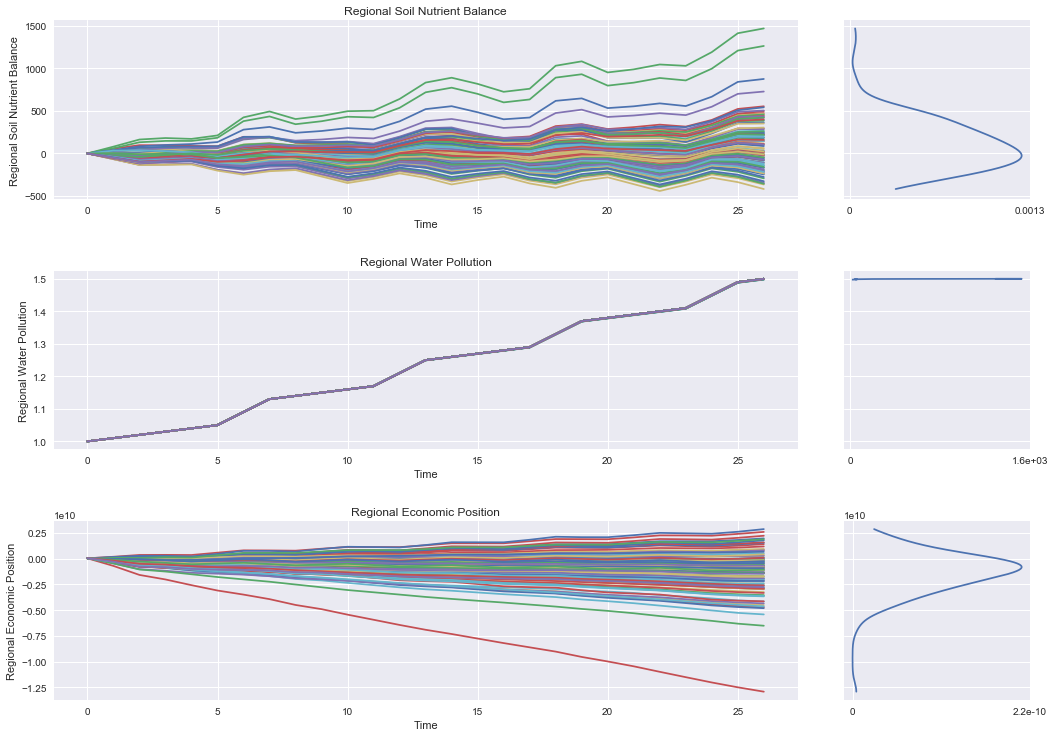

In [17]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [71]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_integ.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_integ.tar.gz


In [18]:
experiments, outcomes= results

In [19]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 91 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.72, coverage: 0.7912087912087912, density: 1.0 restricted_dimensions: 4


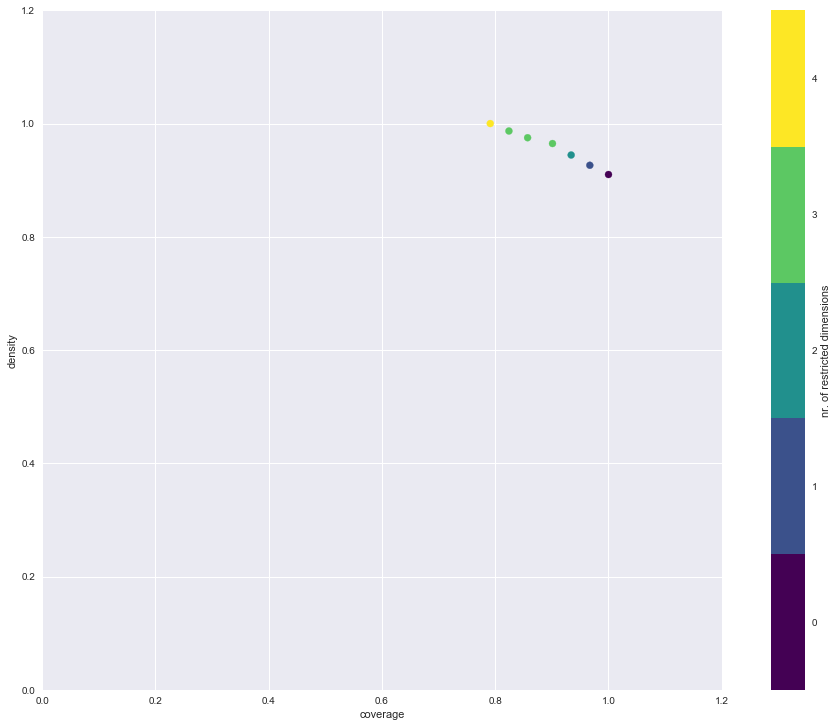

In [20]:
box_1.show_tradeoff()
# mpld3.display()

coverage    0.901099
density     0.964706
mass            0.85
mean        0.964706
res dim            3
Name: 3, dtype: object

                        box 3                                    
                          min          max              qp values
CostIntense          0.629944     1.195734  [0.29014246154525053]
Dredging cost      581.332012  1996.654037  [0.29851621958180885]
ExtShrimpFarmArea    0.823629     1.198658  [0.29851621958180885]



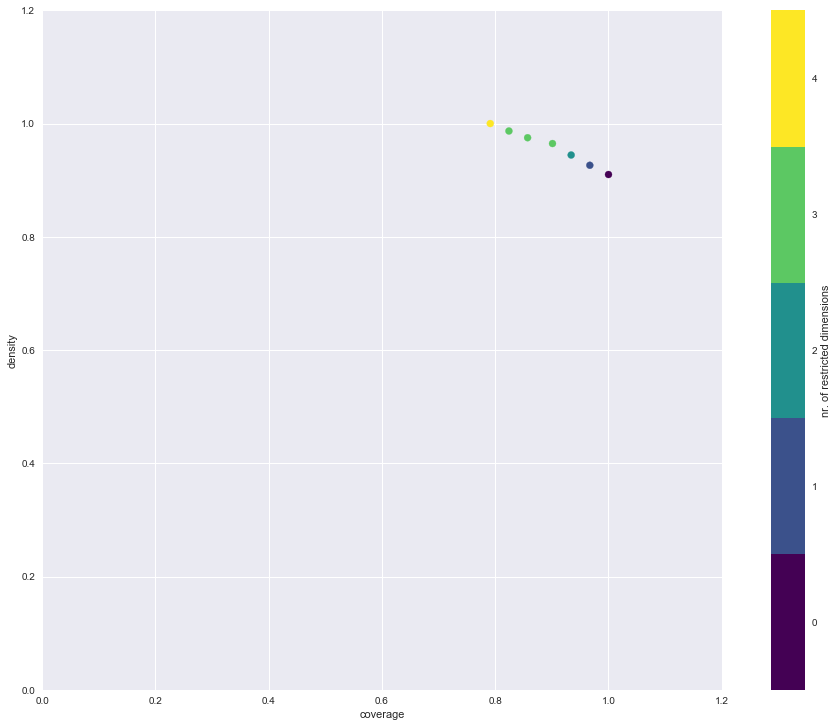

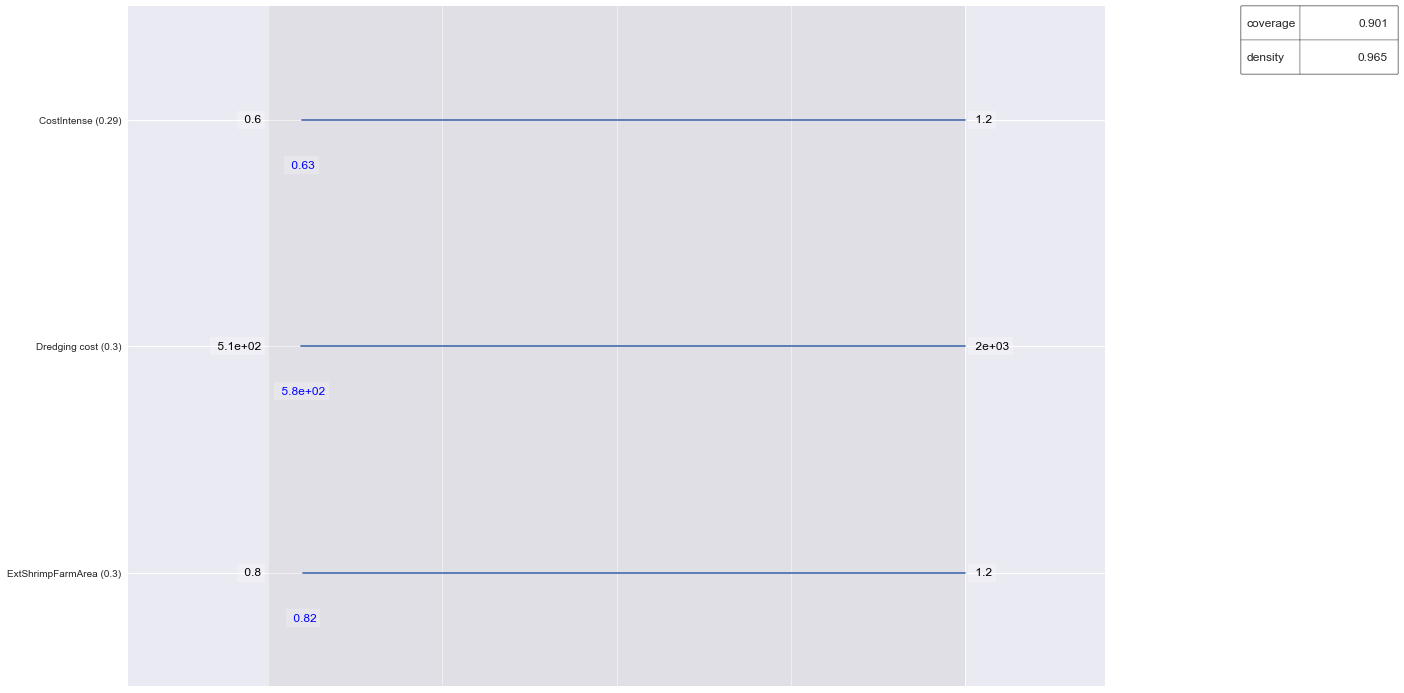

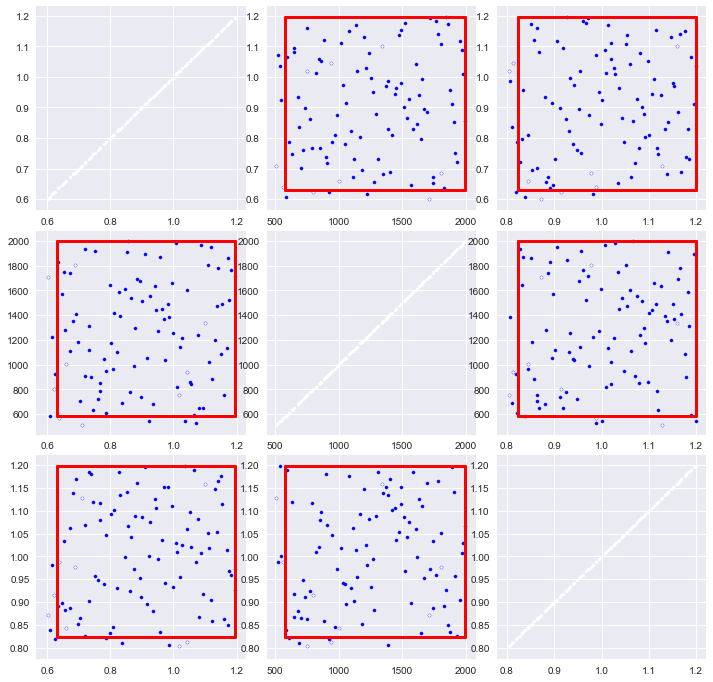

In [21]:
valuebox = 3
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [22]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Regional Economic Position'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>0] = 1
    return classes

prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.6)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 9 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.09, coverage: 1.0, density: 1.0 restricted_dimensions: 13


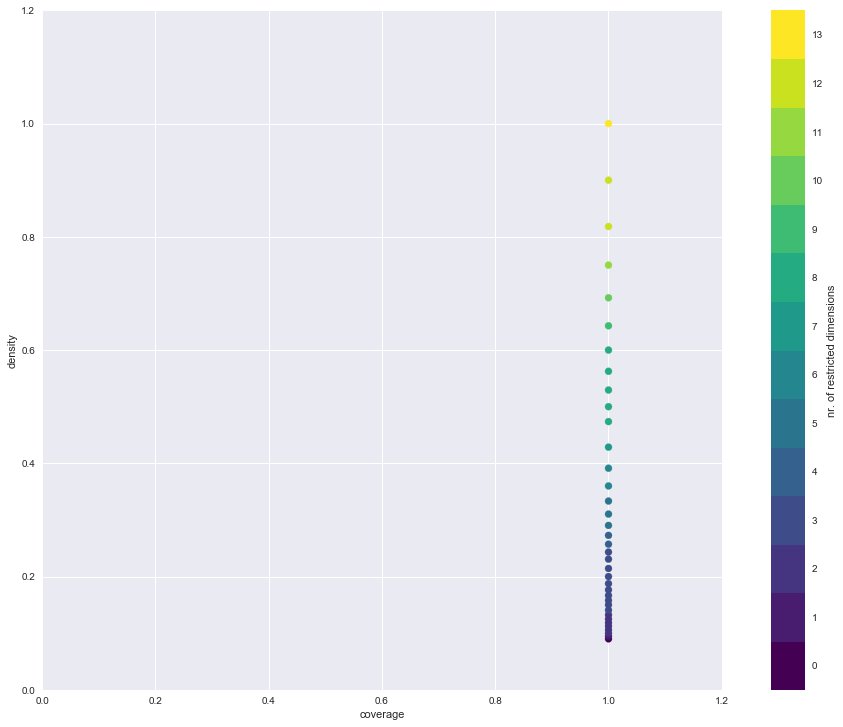

In [23]:
box_1.show_tradeoff()

coverage      1
density     0.9
mass        0.1
mean        0.9
res dim      12
Name: 35, dtype: object

                                                box 35                 \
                                                   min            max   
CostIntense                                   0.601104       1.145888   
CostRiceUnit                                  1.042518       5.905557   
Extensive Shrimp Survival Rate                0.210170       0.399783   
ExogNutAvailRate                              8.779776      14.589606   
CostFresh                                     0.805702       1.709457   
ExtShrimpFarmArea                             0.803645       1.171074   
CostExtense                                   0.030956       0.042948   
BaseTE                                        0.284407       0.387807   
Extense Selling                               3.485960       7.867244   
Dredging cost                               509.775004    1816.891409   
Extensive Shrimp Re

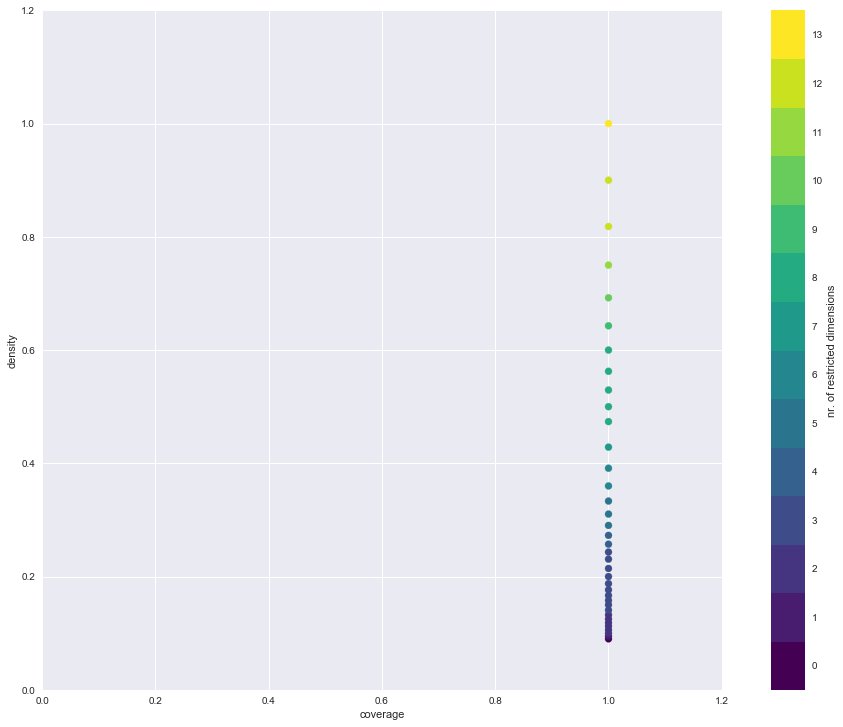

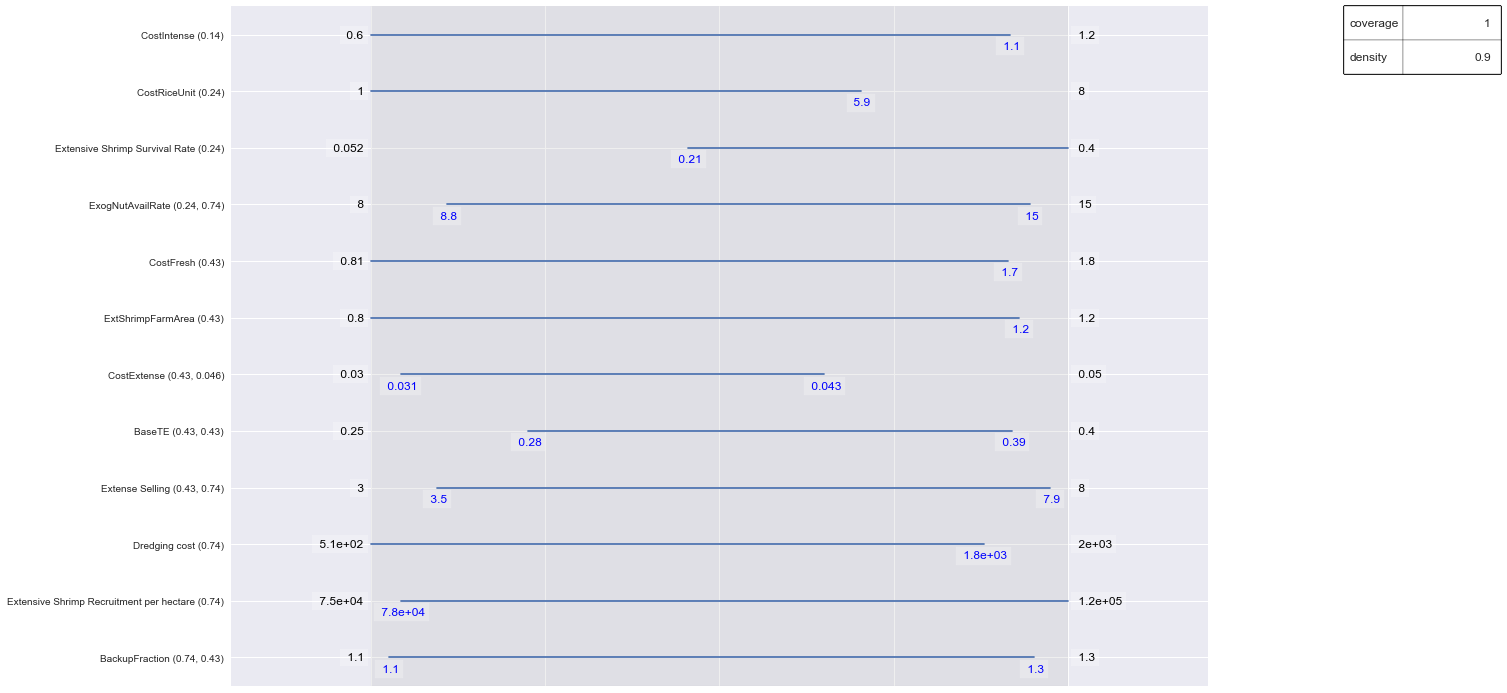

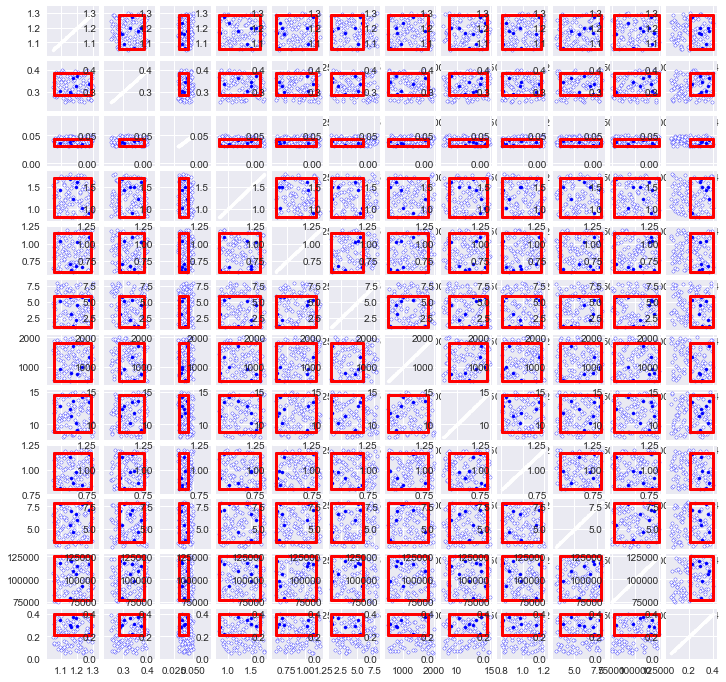

In [24]:
valuebox = 35
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [88]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'Regional Water Pollution'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>1.277] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 95 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.8, coverage: 0.8421052631578947, density: 1.0 restricted_dimensions: 4


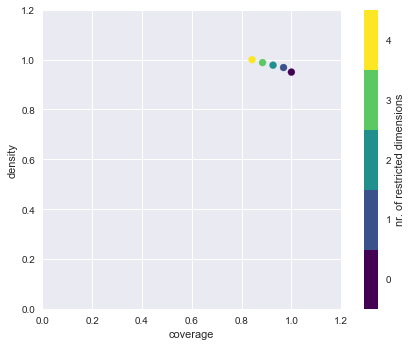

In [89]:
box_1.show_tradeoff()
# mpld3.display()

coverage    0.842105
density            1
mass             0.8
mean               1
res dim            4
Name: 4, dtype: object

                        box 4                                 
                          min       max              qp values
TECoefficient        0.025726  0.039884  [0.14884468555787805]
FertStartPrice       3.235453  7.954112  [0.38799741111690944]
FloodDuration        1.051506  1.998362  [0.38799741111690944]
IntenShrimpFarmArea  0.120240  0.498815  [0.38799741111690944]



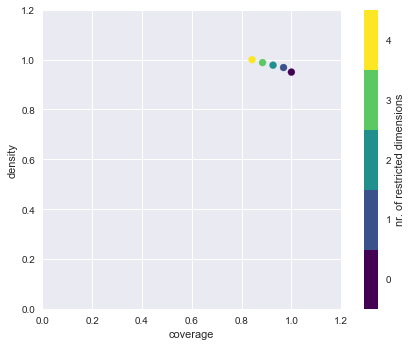

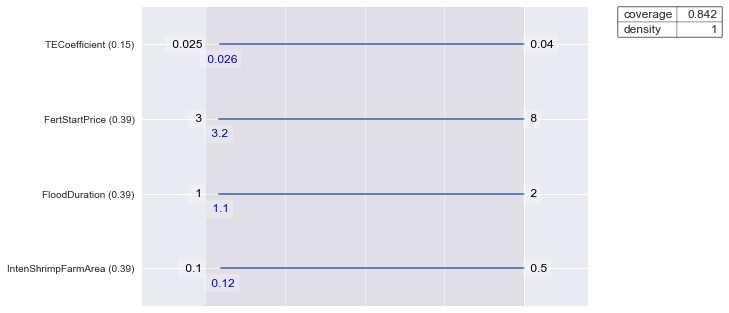

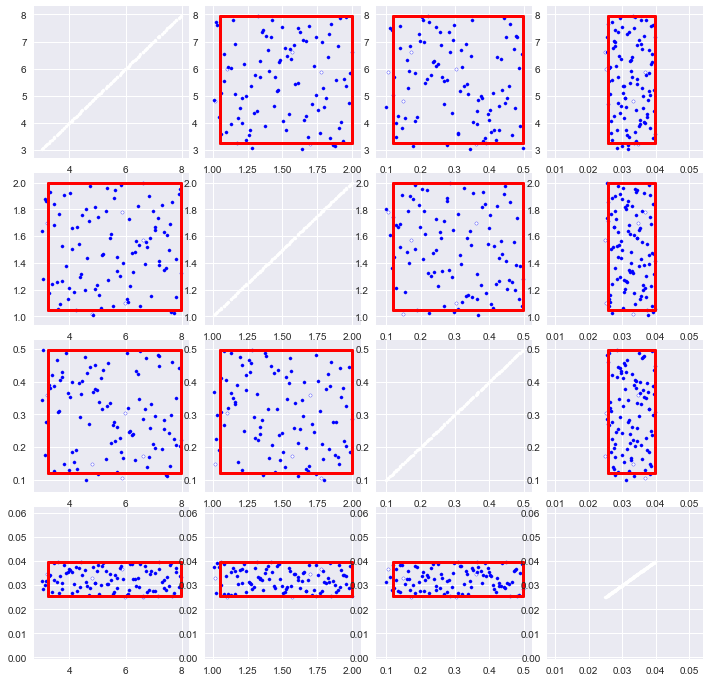

In [90]:
valuebox = 4
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [26]:
def classifyUrbanNon(data):
    ooi = 'Regional Soil Nutrient Balance'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<1000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 100 points remaining, containing 79 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6, coverage: 0.759493670886076, density: 1.0 restricted_dimensions: 5


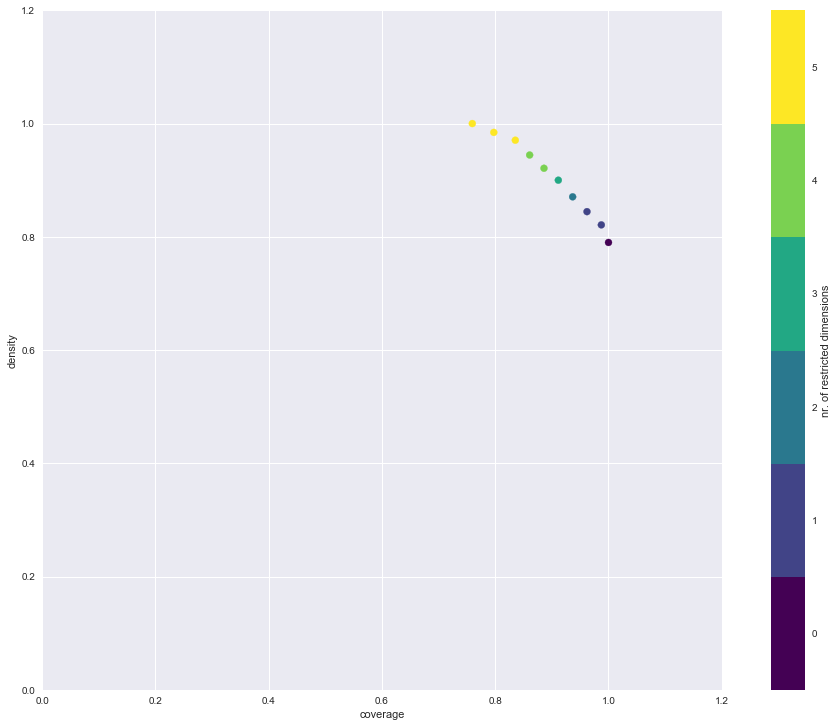

In [27]:
box_2.show_tradeoff()
# mpld3.display()

coverage    0.860759
density     0.944444
mass            0.72
mean        0.944444
res dim            4
Name: 6, dtype: object

                        box 6                                    
                          min         max               qp values
FloodDuration        1.007461    1.898370  [0.081262136704005755]
ExogNutAvailRate     8.659550   14.968051   [0.14168685993727284]
ExtShrimpFarmArea    0.823629    1.198658   [0.20540003122540859]
SedNutContent      270.212154  325.964364   [0.31927911955081872]



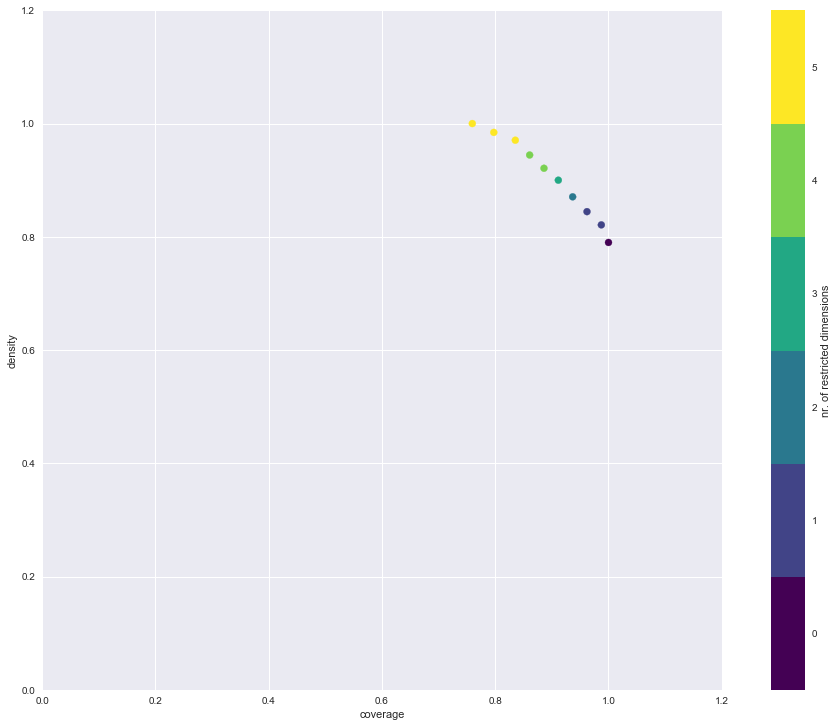

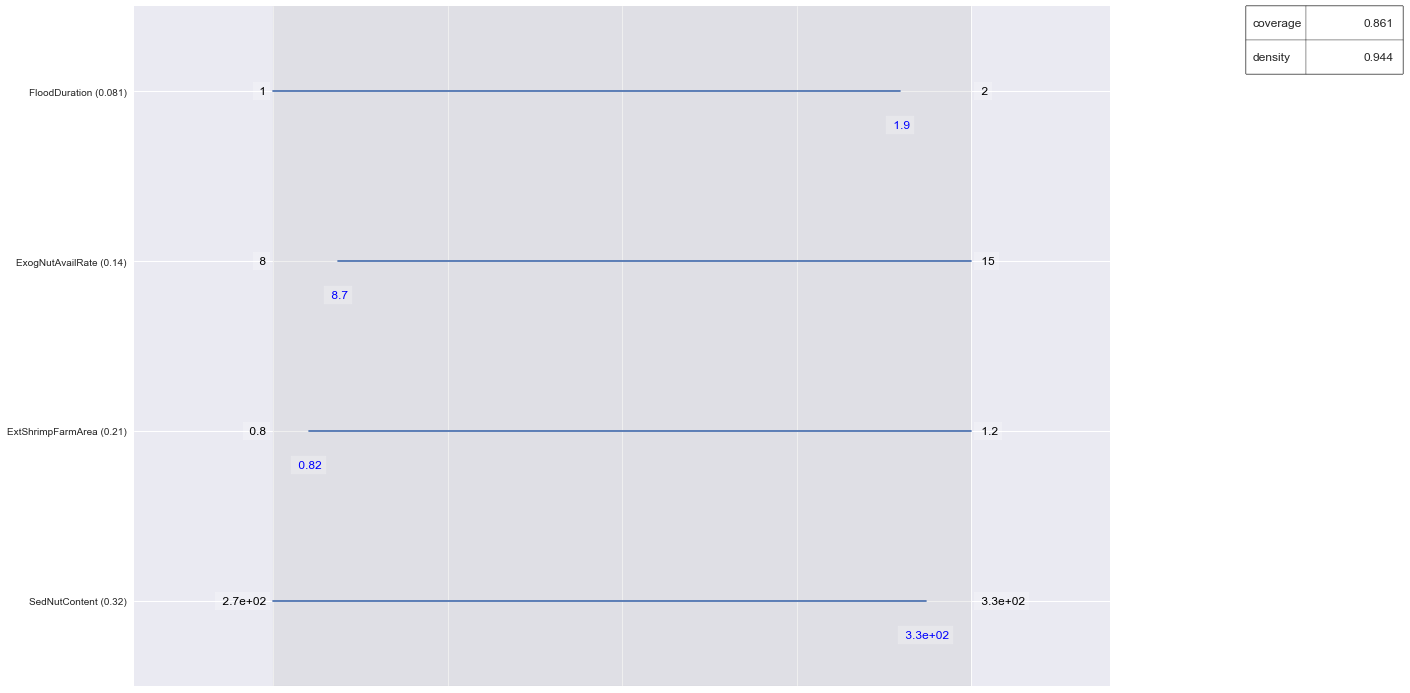

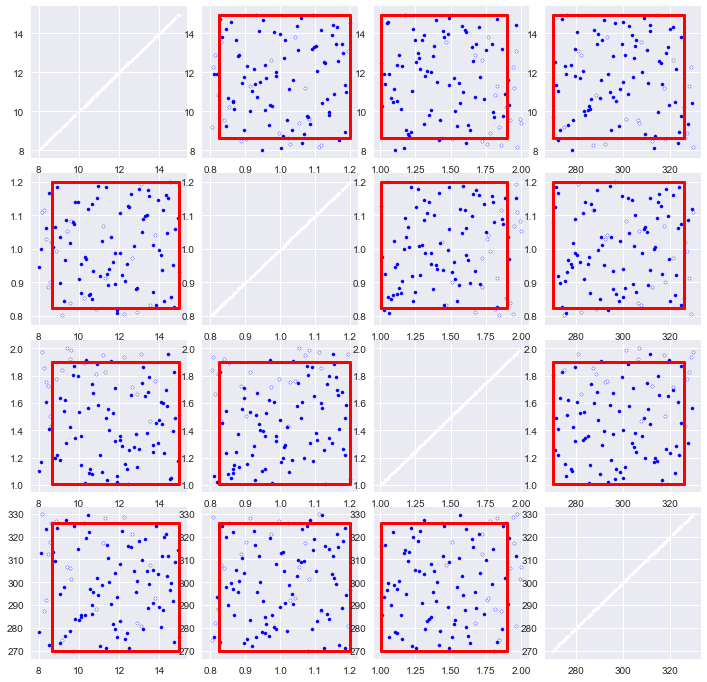

In [28]:
valuebox = 6
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

###  without government intervention, none of the model is compeletely sustainable. These models do not account for government interventions to reduce salinity intrusion, subisdies provided to farmers for integrated models, value creation through training. 

The Model is exposed to increasing uncertainties about salinity, no control over crop failure and market price fluctuations that can affect the selling price of the products. Furthermore, this model does not consider the possibilities of government on waste water treatment which affects the survival rate of shrimp, if farmers don't make invetsments for necessary cleaning infrastructure. 
One insight that can be drawn from all the 3 models is that diversification seems to be the best strategy (even though majority of the outcomes have negative economic position.

Further step is to explore the scenarios which influence the targets, and policy structures will be implemented. Furthermore, time slices will be created to see the short term effects of those policies. 


Maladaptive space critique - 

There may be a case where a strategy may be maladpative inn the shorter duration cycle but may become viable in the longer run. This is very counterintuitive and will be elaborated later with a detailed example.

In [8]:
vensimModel = VensimModel("BaseCaseThanh", model_file="E:\Study\Delft\Coursework\Year_2\Thesis\SD\Model\BenTre_SD_Extend_9_sep_Integ_noRand.vpm" )

In [9]:
vensimModel.uncertainties = [

            RealParameter("UpstreamTrapping", 0.9, 1.1),
            RealParameter("SedNutContent", 270, 330),
            RealParameter("FloodDuration", 0.1, 1),
            RealParameter("ExogNutAvailRate", 8, 15),
            RealParameter("TimeToNutAvailable", 2, 10),     
            RealParameter("MaxNutReqPerHectare", 450, 550),
            RealParameter("YielGrowRate", 1.001, 1.005),
            RealParameter("LeachingRate", 3, 9),
            RealParameter("Salinity Rate", 0.01, 0.1),
            RealParameter("Salinity Fluctuation Intensity", 3, 7),
            RealParameter("crop survival probability", 0.05, 0.3),
            RealParameter("Rate of Degradation", 1, 5),
            RealParameter("BaseTE", 0.25, 0.4),
            RealParameter("TECoefficient", 0.025, 0.04),
            RealParameter("RiceFarmSize", 0.2, 1.5),
            RealParameter("RicePriceChngRate", 1, 1.003),
            RealParameter("RiceStartPrice", 3, 9),
            RealParameter("CostRiceUnit", 1, 8),
            RealParameter("Dredging cost", 750, 1250),
            RealParameter("InitInvestIntenseShrimp", 80000, 120000),
            RealParameter("CostExtense", 0.03, 0.05),
            RealParameter("CostIntense", 0.7, 1),
            RealParameter("CostFresh", 0.5, 0.8),
            RealParameter("IntenShrimpFarmArea",0.1,0.5),
            RealParameter("ExtShrimpFarmArea", 0.8, 1.2),
            RealParameter("intenseSelling", 0.6, 1.3),
            RealParameter("Extense Selling", 3, 8),
            RealParameter("Fresh Selling", 9, 15),
            RealParameter("Extensive Shrimp Recruitment per hectare", 75000, 100000),
            RealParameter("Extensive Shrimp Survival Rate", 0.1, 0.4),
            RealParameter("Intensive Shrimp recruitment per hectare", 900000, 1100000),
            RealParameter("Intensive Shrimp Survival Rate", 0.7, 0.98),
            RealParameter("Freshwater Shrimp Recruitment per hectare", 10000 ,25000),
            RealParameter("Freshwater Shrimp Survival Rate",0.2, 0.5),
            RealParameter("MinWage",5000,10000),
            RealParameter("BackupFraction",1.05,1.3),
            RealParameter("FertPriceChngRate",1.01,1.05),
            RealParameter("FertStartPrice",3,7),   
#             RealParameter("PopFracExtensive", 0, 0.5),
            RealParameter("PopFracInteg", 0.5, 1)    
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Regional Soil Nutrient Balance'),
    TimeSeriesOutcome('Regional Water Pollution'),
    TimeSeriesOutcome('Regional Economic Position')
]

In [10]:
results = perform_experiments(vensimModel, 100, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [11]:
results_name = './BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_norand.tar.gz


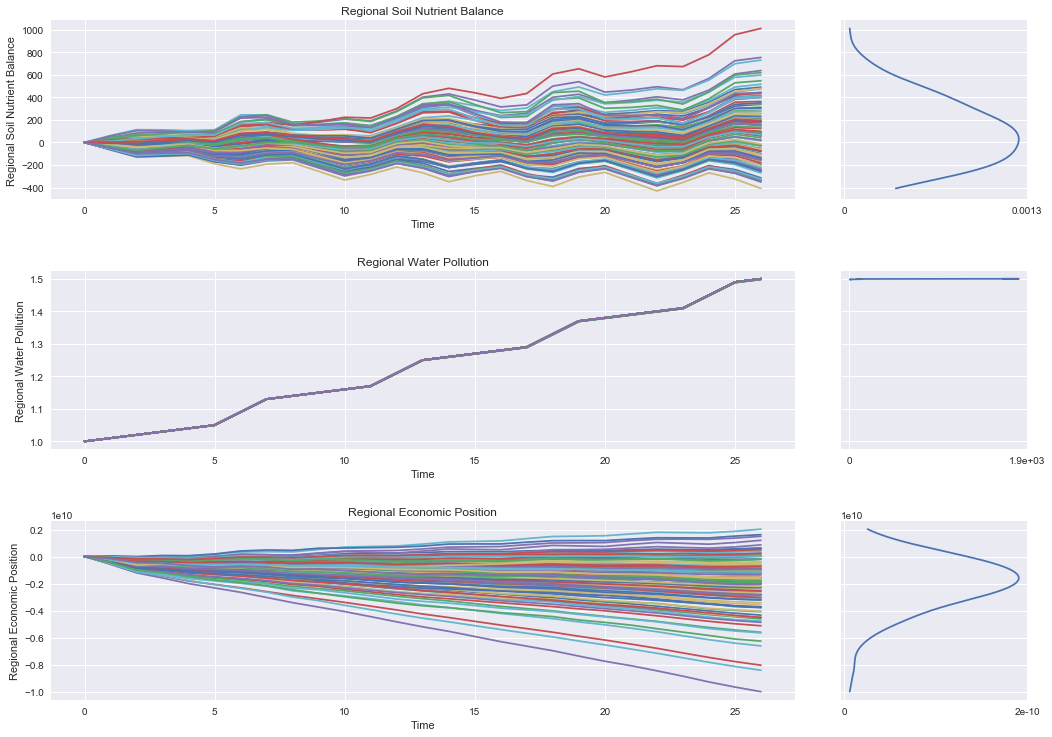

In [12]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.show() #show figure

In [56]:
plt.rcParams["figure.figsize"] = (17.5,12.5)

In [34]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_up.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Coursework\Year_2\Thesis\SD\Code\BenTre_SD_Test_BaseCase_LHS_100_ThanhPhu_up.tar.gz


In [1]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], density=KDE)
plt.show()

NameError: name 'results' is not defined